<a href="https://colab.research.google.com/github/atulgupta01/EVA_Group_Assignment/blob/master/Assignment%2018/EVA_Assignment_18_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import dlib
import cv2
import numpy as np
import faceBlendCommon as fbc
from renderFace import renderFace
import matplotlib.pyplot as plt
import matplotlib
import os
import sys
import math
from google.colab.patches import cv2_imshow
%matplotlib inline

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


### Frame Extraction from input video

In [111]:
ROOT_DIR = os.getcwd()
INPUT_VIDEO_PATH = '/content/drive/My Drive/TSAI/Session18/Video_File.mp4'
FRAME_SAVE_DIR = '/content/drive/My Drive/TSAI/Session18/Frames'

cap = cv2.VideoCapture(INPUT_VIDEO_PATH)
if(cap.isOpened()==False):
  print("Unable to load video")

# Check if frame save directory exist. Else create the same
try:
  if not os.path.exists(FRAME_SAVE_DIR):
    os.makedirs(FRAME_SAVE_DIR)
except OSError:
  print ('Error: Creating directory of data')

frame_count = 0

while True:
    ret, frame = cap.read()
    # Bail out when the video file ends
    if not ret:
        break

    # Video orientation is horizontal so rotate it by 90 degree
    frame = cv2.rotate(frame, cv2.ROTATE_90_CLOCKWISE)
   
    # frames are too large so resize them
    frame = cv2.resize(frame,(0,0), fx = 0.2,fy = 0.2,interpolation = cv2.INTER_CUBIC)
    
    frame_count += 1
    name = '{0}.jpg'.format(frame_count)
    name = os.path.join(FRAME_SAVE_DIR, name)
    
    cv2.imwrite(name, frame)
     
cap.release()
print('Extracted {} frames to {}'.format(frame_count,FRAME_SAVE_DIR))


Extracted 232 frames to /content/drive/My Drive/TSAI/Session18/Frames


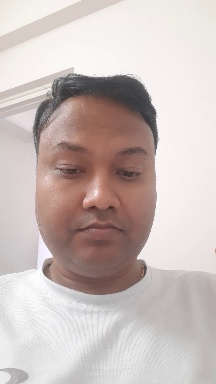

In [112]:
# show one of the frames
name = os.path.join(FRAME_SAVE_DIR,'1.jpg')
demoImg = cv2.imread(name)
cv2_imshow(demoImg)

### Alignment using 5-point model


In [113]:
# Download the 5-point model
!wget -nd https://github.com/justadudewhohacks/face-recognition.js-models/blob/master/models/shape_predictor_5_face_landmarks.dat
# copy the model to google drive
%cp shape_predictor_5_face_landmarks.dat ./drive/My\ Drive/TSAI/Session18

--2020-02-21 09:08:24--  https://github.com/justadudewhohacks/face-recognition.js-models/blob/master/models/shape_predictor_5_face_landmarks.dat
Resolving github.com (github.com)... 192.30.253.113
Connecting to github.com (github.com)|192.30.253.113|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘shape_predictor_5_face_landmarks.dat.1’

shape_predictor_5_f     [ <=>                ]  66.58K  --.-KB/s    in 0.03s   

2020-02-21 09:08:25 (2.53 MB/s) - ‘shape_predictor_5_face_landmarks.dat.1’ saved [68173]



In [0]:
PREDICTOR_PATH = "/content/drive/My Drive/TSAI/Session18/shape_predictor_5_face_landmarks.dat"
# Get the face detector
faceDetector = dlib.get_frontal_face_detector()
# The landmark detector is implemented in the shape_predictor class
landmarkDetector = dlib.shape_predictor(PREDICTOR_PATH)

In [0]:
# Check alignment code on single image before running it for all the frames

# Read image
name = os.path.join(FRAME_SAVE_DIR,'1.jpg')
demoImg = cv2.imread(name)

# Detect landmarks.
points = fbc.getLandmarks(faceDetector, landmarkDetector, demoImg)
points = np.array(points)

# Convert image to floating point in the range 0 to 1
im = np.float32(demoImg)/255.0

# Dimensions of output image
h = demoImg.shape[0]
w = demoImg.shape[1]

# Normalize image to output coordinates.
imNorm, points = fbc.normalizeImagesAndLandmarks((h, w), im, points)

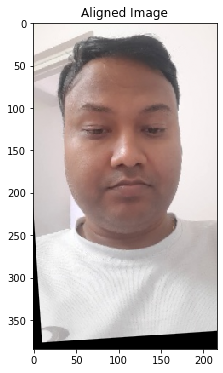

In [116]:
imNorm = np.uint8(imNorm*255)

# Display the results
plt.imshow(imNorm[:,:,::-1])
plt.title("Aligned Image")
plt.show()

In [117]:
# Apply alignment on all the extracted frames

import glob

# make a list of frames in the input folder
frameList = list(glob.iglob(os.path.join(FRAME_SAVE_DIR, '*.*')))
# Sort the images by integer index
frameList = sorted(frameList, key=lambda x: float(os.path.split(x)[1][:-3]))

# Aligned frames will be saved to ALIGNED_FRAME_DIR
ALIGNED_FRAME_DIR = '/content/drive/My Drive/TSAI/Session18/Aligned'

try:
  if not os.path.exists(ALIGNED_FRAME_DIR):
    os.makedirs(ALIGNED_FRAME_DIR)
except OSError:
  print ('Error: Creating directory of Aligned Frames')


for imgPath in frameList:
  img = cv2.imread(imgPath)
  # Detect landmarks.
  points = fbc.getLandmarks(faceDetector, landmarkDetector, img)
  points = np.array(points)

  # Convert image to floating point in the range 0 to 1
  im = np.float32(img)/255.0

  # Dimensions of output image
  h = demoImg.shape[0]
  w = demoImg.shape[1]

  # Normalize image to output coordinates.
  imNorm, points = fbc.normalizeImagesAndLandmarks((h, w), im, points)

  imNorm = np.uint8(imNorm*255)

  # save aligned image with the same name in ALIGNED_FRAME_DIR
  imgName = imgPath.split('/')[-1]
  alignedImgPath = os.path.join(ALIGNED_FRAME_DIR,imgName)
  cv2.imwrite(alignedImgPath,imNorm)
  
print('Alignment using 5-pt model done!!')

Alignment using 5-pt model done!!


### Landmark detection and stabilization

In [40]:
!wget -nd https://github.com/JeffTrain/selfie/raw/master/shape_predictor_68_face_landmarks.dat
!cp shape_predictor_68_face_landmarks.dat ./drive/My\ Drive/TSAI/Session18

--2020-02-21 05:21:33--  https://github.com/JeffTrain/selfie/raw/master/shape_predictor_68_face_landmarks.dat
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/JeffTrain/selfie/master/shape_predictor_68_face_landmarks.dat [following]
--2020-02-21 05:21:33--  https://raw.githubusercontent.com/JeffTrain/selfie/master/shape_predictor_68_face_landmarks.dat
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 99693937 (95M) [application/octet-stream]
Saving to: ‘shape_predictor_68_face_landmarks.dat’

shape_predictor_68_ 100%[===================>]  95.08M   173MB/s    in 0.5s    

2020-02-21 05:21:35 (173 MB/s) 

In [0]:
# Input data path
DATA_PATH = ALIGNED_FRAME_DIR
# Landmark model location
PREDICTOR_PATH = "/content/drive/My Drive/TSAI/Session18/shape_predictor_68_face_landmarks.dat"
# Get the face detector
faceDetector = dlib.get_frontal_face_detector()
# The landmark detector is implemented in the shape_predictor class
landmarkDetector = dlib.shape_predictor(PREDICTOR_PATH)

In [0]:
# Function to calculate the intereye distance.
def interEyeDistance(predict):
  leftEyeLeftCorner = (predict[36].x, predict[36].y)
  rightEyeRightCorner = (predict[45].x, predict[45].y)
  distance = cv2.norm(np.array(rightEyeRightCorner) - np.array(leftEyeLeftCorner))
  distance = int(distance)
  return distance

In [0]:
RESIZE_HEIGHT = 480

winSize = 101
maxLevel = 10

# Frames with unstabilized landmarks will be save at UNSTABLE_FRAME_DIR 
UNSTABLE_FRAME_DIR = '/content/drive/My Drive/TSAI/Session18/Unstable'

try:
  if not os.path.exists(UNSTABLE_FRAME_DIR):
    os.makedirs(UNSTABLE_FRAME_DIR)
except OSError:
  print ('Error: Creating directory for Unstable landmark Frames')

# Frames with stabilized landmarks will be save at STABLE_FRAME_DIR
STABLE_FRAME_DIR = '/content/drive/My Drive/TSAI/Session18/Stable'

try:
  if not os.path.exists(STABLE_FRAME_DIR):
    os.makedirs(STABLE_FRAME_DIR)
except OSError:
  print ('Error: Creating directory for stable landmark Frames')


# Apply the alignment on all the extracted frames

# make a list of frames in the aligned frames folder
alignedFrameList = list(glob.iglob(os.path.join(ALIGNED_FRAME_DIR, '*.*')))
# Sort the images by integer index
alignedFrameList = sorted(alignedFrameList, key=lambda x: float(os.path.split(x)[1][:-3]))

imPrev = cv2.imread(alignedFrameList[0])

# Finding the size of the image.
size = imPrev.shape[0:1]

# Initializing the parameters
points=[]
pointsPrev=[]
pointsDetectedCur=[]
pointsDetectedPrev=[]
eyeDistanceNotCalculated = True
eyeDistance = 0

isFirstFrame = True
# Initial value, actual value calculated after 100 frames
count =0

In [125]:
for imgPath in alignedFrameList:

  # Grab a frame
  im = cv2.imread(imgPath)

  imDlib = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
  # COnverting to grayscale
  imGray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
  # print(imgPath)
  if (count==0):
    imGrayPrev = imGray

  height = im.shape[0]
  IMAGE_RESIZE = float(height)/RESIZE_HEIGHT

  # Resize image for faster face detection
  imSmall = cv2.resize(im, None, fx=1.0/IMAGE_RESIZE, fy=1.0/IMAGE_RESIZE,interpolation = cv2.INTER_LINEAR)
  imSmallDlib = cv2.cvtColor(imSmall, cv2.COLOR_BGR2RGB)
  
  faces = faceDetector(imSmallDlib,0)

  # If no face was detected
  if len(faces)==0:
    print("No face detected in {}".format(imgPath))

  # If faces are detected, iterate through each image and detect landmark points
  else:
    for i in range(0,len(faces)):
      #print("face detected")
      # Face detector was found over a smaller image.
      # So, we scale face rectangle to correct size.
      newRect = dlib.rectangle(int(faces[i].left() * IMAGE_RESIZE),
        int(faces[i].top() * IMAGE_RESIZE),
        int(faces[i].right() * IMAGE_RESIZE),
        int(faces[i].bottom() * IMAGE_RESIZE))
      
      # Detect landmarks in current frame
      landmarks = landmarkDetector(imDlib, newRect).parts()
      
      # Handling the first frame of video differently,for the first frame copy the current frame points
      
      if (isFirstFrame==True):
        pointsPrev=[]
        pointsDetectedPrev = []
        [pointsPrev.append((p.x, p.y)) for p in landmarks]
        [pointsDetectedPrev.append((p.x, p.y)) for p in landmarks]
        isFirstFrame = False

      # If not the first frame, copy points from previous frame.
      else:
        pointsPrev=[]
        pointsDetectedPrev = []
        pointsPrev = points
        pointsDetectedPrev = pointsDetectedCur

      # pointsDetectedCur stores results returned by the facial landmark detector
      # points stores the stabilized landmark points
      points = []
      pointsDetectedCur = []
      [points.append((p.x, p.y)) for p in landmarks]
      [pointsDetectedCur.append((p.x, p.y)) for p in landmarks]

      # Convert to numpy float array
      pointsArr = np.array(points,np.float32)
      pointsPrevArr = np.array(pointsPrev,np.float32)

      # If eye distance is not calculated before
      if eyeDistanceNotCalculated:
        eyeDistance = interEyeDistance(landmarks)
        eyeDistanceNotCalculated = False

      if eyeDistance > 100:
        dotRadius = 3
      else:
        dotRadius = 2

      sigma = eyeDistance * eyeDistance / 400
      s = 2*int(eyeDistance/4)+1

      #  Set up optical flow params
      lk_params = dict(winSize  = (s, s), maxLevel = 5, criteria = (cv2.TERM_CRITERIA_COUNT | cv2.TERM_CRITERIA_EPS, 20, 0.03))
      # Python Bug. Calculating pyramids and then calculating optical flow results in an error. So directly images are used.
      #ret, imGrayPyr= cv2.buildOpticalFlowPyramid(imGray, (winSize,winSize), maxLevel)

      pointsArr,status, err = cv2.calcOpticalFlowPyrLK(imGrayPrev,imGray,pointsPrevArr,pointsArr,**lk_params)
      

      # Converting to float
      pointsArrFloat = np.array(pointsArr,np.float32)

      # Converting back to list
      points = pointsArrFloat.tolist()

      # Final landmark points are a weighted average of
      # detected landmarks and tracked landmarks
      for k in range(0,len(landmarks)):
        d = cv2.norm(np.array(pointsDetectedPrev[k]) - np.array(pointsDetectedCur[k]))
        alpha = math.exp(-d*d/sigma)
        points[k] = (1 - alpha) * np.array(pointsDetectedCur[k]) + alpha * np.array(points[k])

      # Make a copy of input image to write unstabilized landmarks
      imUnstab = im.copy()     

      # Drawing over the unstabilized landmark points   
      for p in pointsDetectedCur:
        cv2.circle(imUnstab,(int(p[0]),int(p[1])),dotRadius, (0,0,255),-1)
  
      # Drawing over the stabilized landmark points
      for p in points:
        cv2.circle(im,(int(p[0]),int(p[1])),dotRadius, (255,0,0),-1)

      count = count+1

      # save stabilized landmark image with the same name in STABLE_FRAME_DIR
      imgName = imgPath.split('/')[-1]
      stableImgPath = os.path.join(STABLE_FRAME_DIR,imgName)
      #imNorm = np.uint8(imNorm*255)
      cv2.imwrite(stableImgPath,im)   

      # save unstabilized landmark image with the same name in UNSTABLE_FRAME_DIR
      unStableImgPath = os.path.join(UNSTABLE_FRAME_DIR,imgName)
      cv2.imwrite(unStableImgPath,imUnstab)
      # Getting ready for next frame
      imPrev = im
      imGrayPrev = imGray

print('{0} frames processed'.format(count))   
print('UnStable landmark frames saved to {}'.format(UNSTABLE_FRAME_DIR))   
print('Stabilized landmark frames saved to {}'.format(STABLE_FRAME_DIR))   


928 frames processed
UnStable landmark frames saved to /content/drive/My Drive/TSAI/Session18/Unstable
Stabilized landmark frames saved to /content/drive/My Drive/TSAI/Session18/Stable


### Create Video
Concatenate original frames, unstable landmark frames and stable landmark frames. Combine them to create a video file

In [128]:
import os
import cv2
import numpy as np
import sys

from google.colab.patches import cv2_imshow
from cv2 import VideoWriter, VideoWriter_fourcc, imread
import glob



is_color=True
format="FMP4"
  
  

images1 = list(glob.iglob(os.path.join(FRAME_SAVE_DIR, '*.*')))
# Sort the images by integer index
images1 = sorted(images1, key=lambda x: float(os.path.split(x)[1][:-3]))

# make a list of images in path1
images2 = list(glob.iglob(os.path.join(UNSTABLE_FRAME_DIR, '*.*')))
# Sort the images by integer index
images2 = sorted(images2, key=lambda x: float(os.path.split(x)[1][:-3]))


# make a list of images in path1
images3 = list(glob.iglob(os.path.join(STABLE_FRAME_DIR, '*.*')))
# Sort the images by integer index
images3 = sorted(images3, key=lambda x: float(os.path.split(x)[1][:-3]))


  
fourcc = VideoWriter_fourcc(*format)
vid = None
for i in range(len(images1)):
  #print("Stitching {0},{1} and {2}".format(images1[i],images2[i],images3[i]))

  if not os.path.exists(images1[i]):
    raise FileNotFoundError(images1[i])

  img1 = imread(images1[i])

  if not os.path.exists(images2[i]):
    raise FileNotFoundError(images2[i])

  img2 = imread(images2[i])
  
  if not os.path.exists(images3[i]):
    raise FileNotFoundError(images3[i])

  img3 = imread(images3[i])

  combinedImg = cv2.hconcat([img1,img2])
  combinedImg = cv2.hconcat([combinedImg,img3])

  if vid is None:

      size = combinedImg.shape[1], combinedImg.shape[0]
      vid = VideoWriter('out.mp4', fourcc, float(25), size, is_color)

  vid.write(combinedImg)
vid.release()

print('Video created!!!')

Video created!!!
